In [1]:
##### Jimi Togni
#IE009

from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels.tsa.stattools as st
from numpy.linalg import matrix_power, inv, pinv
from scipy import stats
from scipy.fft import fft, ifft, fftfreq
import pysepm


In [2]:
### metodos
def db(x):
    return 10*np.log10(np.absolute(x))

In [3]:
retordo_db = db()

TypeError: db() missing 1 required positional argument: 'x'

In [4]:
# wavfile.read retorna dois dados
# 1 Taxa de amostragem do arquivo WAV em int
# 2 datanumpy array - Data read from WAV file. Data-type is determined from the file;
fs, audio = wavfile.read("44_com_ruido_sem_tratamento.wav") #audio inicial com ruido normal do ambiente

In [ ]:
power = audio**2
power_avg_db = db(np.mean(power))

In [10]:
audio.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [ ]:
#Processamento do áudio e adição do ruído

SNR = 0
noise_db = power_avg_db - SNR
noise_watt = 10**(noise_db/10)
noise = np.random.normal(0, np.sqrt(noise_watt), len(audio))
audio_noise = audio + noise
print("audio = $ tipo %", audio, audio.shape)
print("noise = {} tipo {}", noise, noise.shape)
print("=================")
print("audio[:33075] = ", audio[:33075])
print("audio_noise[:33075] = ", audio_noise[:33075])

In [13]:
wavfile.write("44_com_ruido_sem_tratamento.wav", fs, audio_noise.astype(np.int16))
ruido_power = (audio[:33075] - audio_noise[:33075])**2
ruido_db = 10*np.log10(np.mean(ruido_power))
SNR = power_avg_db - ruido_db
print('SNR inicial = ', SNR, '\n')

#Matriz de Transição
p = 10
print('p = ', p, '\n')
y = audio_noise
Ry = np.zeros((p,p))
ryy = np.zeros((2*p+1,1))
for i in range(2*p+1):            
    aux = np.zeros(y.shape)
    aux[:len(y)-i] = y[i:]
    ryy[i][0] = np.mean(aux*y)
for i in range(p):
    Ry[i,:] = ryy[i+1:i+p+1,0]    
a = np.matmul(np.linalg.inv(Ry),ryy[1+p:,:])
A = np.zeros((p,p))
A[:p-1,1:] = np.identity(p-1)
A[p-1,:] = a[:,0]
w, z = np.linalg.eig(A)
print('Autovalores de A (módulo):', abs(w), '\n')

#Filtro de Kalman iterativo
xnn_1 = np.zeros((p,1))
xn1n = np.zeros((p,1))
e = np.zeros((len(y)))
H = np.zeros((1,p))
H[0][p-1] = 1
K = np.zeros((p,1))
I = np.identity(p)
for k in range(10):
    for n in range(1,len(y)):
        e[n] = y[n] - np.dot(H,xnn_1)
        xnn = xnn_1 + K*e[n]
        xn1n = np.dot(A, xnn)
        xnn_1 = xn1n
    ree = np.zeros((p+1,1))
    for i in range(p+1):    
        aux = np.zeros(e.shape)
        aux[:len(e)- i] = e[i:]
        ree[i][0] = np.mean(aux*e)
    M = np.zeros((p,p))
    for i in range(p):
        M[i,:] = np.dot(H,np.dot(matrix_power(np.dot(A,(I - np.dot(K,H))),i),A))    
    aux = np.zeros((p,1))
    aux[:,0] = ree[1:,0]
    K = K + np.dot(inv(M),aux)/ree[0][0]
print('Autocorrelação de e(n):', '\n', ree, '\n')
print('Ganho de Kalman:', '\n', K, '\n')

#Estimação da Saída
s_hat = np.zeros((len(y)))
xnn_1 = np.zeros((p,1))
for n in range(1,len(y)):
    e[n] = y[n] - np.dot(H,xnn_1)
    xnn = xnn_1 + K*e[n]
    s_hat[n] = np.dot(H,xnn)
    xn1n = np.dot(A, xnn)
    xnn_1 = xn1n
wavfile.write("44_com_ruido_py_2_6dB.WAV", fs, s_hat.astype(np.int16))
k =  s_hat[:33075] - audio[:33075]
ruido_power = (k)**2
ruido_db = 10*np.log10(np.mean(ruido_power))
SNR = power_avg_db - ruido_db
print('SNR final = ', SNR)

SNR inicial =  -0.0077444832792963325 

p =  10 

Autovalores de A (módulo): [0.97903885 0.97903885 0.99974324 0.99974324 0.74054429 0.74054429
 0.93159309 0.93159309 0.9535587  0.9535587 ] 

Autocorrelação de e(n): 
 [[ 4.94209011e+06]
 [-1.09283697e-01]
 [ 1.10296264e-03]
 [ 1.15148738e-01]
 [ 1.63198551e-01]
 [ 1.09714200e-01]
 [-1.68670646e-02]
 [-1.37198438e-01]
 [-1.76812586e-01]
 [-1.15051465e-01]
 [ 1.40601352e-02]] 

Ganho de Kalman: 
 [[-0.38504065]
 [ 0.83227567]
 [ 0.92957269]
 [ 0.41285657]
 [ 0.60395432]
 [ 0.71596658]
 [ 0.77160101]
 [ 0.81729979]
 [ 0.76350199]
 [ 1.02536271]] 

SNR final =  -0.2302994202441795


###### 

## Diferentes SNR

In [ ]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels.tsa.stattools as st
from numpy.linalg import matrix_power, inv, pinv
from scipy import stats
from scipy.fft import fft, ifft, fftfreq
import pysepm
def db(x):
    return 10*np.log10(np.absolute(x))

SNR = np.arange(-15,2,1)
SNR_i = np.zeros((len(SNR)))
SNR_f = np.zeros((len(SNR)))
fs, audio = wavfile.read("44_com_ruido_sem_tratamento.wav")

for s in range(len(SNR)):
    #Processamento do áudio e adição do ruído
    power = audio**2
    power_avg_db = db(np.mean(power))
    noise_db = power_avg_db - SNR[s]
    noise_watt = 10**(noise_db/10)
    noise = np.random.normal(0, np.sqrt(noise_watt), len(audio))
    audio_noise = audio + noise
    ruido_power = (audio[:33075] - audio_noise[:33075])**2
    ruido_db = 10*np.log10(np.mean(ruido_power))
    SNR_i[s] = power_avg_db - ruido_db
    print('SNR inicial = ', SNR_i[s])

    #Matriz de Transição
    p = 4
    y = audio_noise
    Ry = np.zeros((p,p))
    ryy = np.zeros((2*p+1,1))
    for i in range(2*p+1):            
        aux = np.zeros(y.shape)
        aux[:len(y)-i] = y[i:]
        ryy[i][0] = np.mean(aux*y)
    for i in range(p):
        Ry[i,:] = ryy[i+1:i+p+1,0]    
    a = np.matmul(np.linalg.inv(Ry),ryy[1+p:,:])
    A = np.zeros((p,p))
    A[:p-1,1:] = np.identity(p-1)
    A[p-1,:] = a[:,0]
    w, z = np.linalg.eig(A)

    #Filtro de Kalman iterativo
    xnn_1 = np.zeros((p,1))
    xn1n = np.zeros((p,1))
    e = np.zeros((len(y)))
    H = np.zeros((1,p))
    H[0][p-1] = 1
    K = np.zeros((p,1))
    I = np.identity(p)
    for k in range(10):
        for n in range(1,len(y)):
            e[n] = y[n] - np.dot(H,xnn_1)
            xnn = xnn_1 + K*e[n]
            xn1n = np.dot(A, xnn)
            xnn_1 = xn1n
        ree = np.zeros((p+1,1))
        for i in range(p+1):    
            aux = np.zeros(e.shape)
            aux[:len(e)- i] = e[i:]
            ree[i][0] = np.mean(aux*e)
        M = np.zeros((p,p))
        for i in range(p):
            M[i,:] = np.dot(H,np.dot(matrix_power(np.dot(A,(I - np.dot(K,H))),i),A))    
        aux = np.zeros((p,1))
        aux[:,0] = ree[1:,0]
        K = K + np.dot(inv(M),aux)/ree[0][0]

    s_hat = np.zeros((len(y)))
    xnn_1 = np.zeros((p,1))
    for n in range(1,len(y)):
        e[n] = y[n] - np.dot(H,xnn_1)
        xnn = xnn_1 + K*e[n]
        s_hat[n] = np.dot(H,xnn)
        xn1n = np.dot(A, xnn)
        xnn_1 = xn1n
    k =  s_hat[:33075] - audio[:33075]
    ruido_power = (k)**2
    ruido_db = 10*np.log10(np.mean(ruido_power))
    SNR_f[s] = power_avg_db - ruido_db
    print('SNR final = ', SNR_f[s], '\n')
    
plt.rcParams.update({'font.size': 13.5})
plt.figure(figsize=(6,6))
plt.plot(SNR_i, SNR_f)
plt.xticks(np.arange(-15,0,3))
plt.yticks(np.arange(-23,-15,3))
plt.xlabel('SNR da entrada (dB)')
plt.ylabel('SNR da saída (dB)')
plt.grid(True)

In [56]:
import librosa

audio_original_ft = librosa.load("19_com_ruido_sem_tratamento.wav")

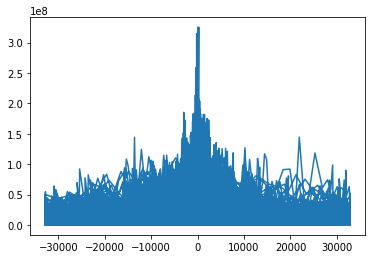

In [59]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
rate, data = wav.read('19_com_ruido_sem_tratamento.wav')
fft_out = fft(data)
%matplotlib inline
plt.plot(data, np.abs(fft_out))
plt.show()

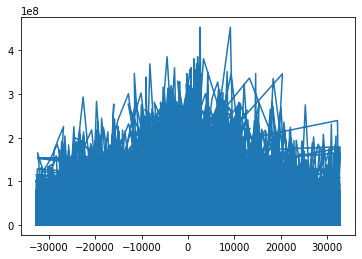

In [62]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
rate, data = wav.read('19_com_ruido_py_2_6dB.WAV')
fft_out = fft(data)
%matplotlib inline
plt.plot(data, np.abs(fft_out))
plt.show()

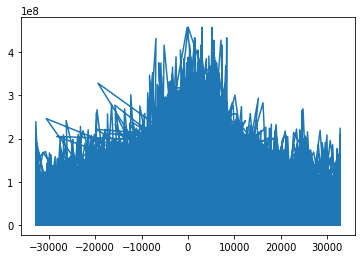

In [64]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
rate, data = wav.read('45_com_ruido_sem_tratamento.wav')
fft_out = fft(data)
%matplotlib inline
plt.plot(data, np.abs(fft_out))
plt.show()

## y = s_hat

In [35]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels.tsa.stattools as st
from numpy.linalg import matrix_power, inv, pinv
from scipy import stats
from scipy.fft import fft, ifft, fftfreq
import pysepm
def db(x):
    return 10*np.log10(np.absolute(x))

#Processamento do áudio e adição do ruído
fs, audio = wavfile.read("44_com_ruido_sem_tratamento.wav")
power = audio**2
power_avg_db = db(np.mean(power))
SNR = 0
noise_db = power_avg_db - SNR
noise_watt = 10**(noise_db/10)
noise = np.random.normal(0, np.sqrt(noise_watt), len(audio))
audio_noise = audio + noise
wavfile.write("cel__com_ruido_fala_ruido_2.WAV", fs, audio_noise.astype(np.int16))
ruido_power = (audio[:33075] - audio_noise[:33075])**2
ruido_db = 10*np.log10(np.mean(ruido_power))
SNR = power_avg_db - ruido_db
s_hat = audio_noise
SNR_f = np.zeros((10))

for j in range(len(SNR_f)):
    #Matriz de Transição
    ruido_power = (audio[:123075] - s_hat[:123075])**2
    ruido_db = 10*np.log10(np.mean(ruido_power))
    SNR = power_avg_db - ruido_db
    print('SNR inicial = ', SNR)
    p = 8
    y = s_hat
    Ry = np.zeros((p,p))
    ryy = np.zeros((2*p+1,1))
    for i in range(2*p+1):            
        aux = np.zeros(y.shape)
        aux[:len(y)-i] = y[i:]
        ryy[i][0] = np.mean(aux*y)
    for i in range(p):
        Ry[i,:] = ryy[i+1:i+p+1,0]    
    a = np.matmul(np.linalg.inv(Ry),ryy[1+p:,:])
    A = np.zeros((p,p))
    A[:p-1,1:] = np.identity(p-1)
    A[p-1,:] = a[:,0]
    w, z = np.linalg.eig(A)

    #Filtro de Kalman iterativo
    xnn_1 = np.zeros((p,1))
    xn1n = np.zeros((p,1))
    e = np.zeros((len(y)))
    H = np.zeros((1,p))
    H[0][p-1] = 1
    K = np.zeros((p,1))
    I = np.identity(p)
    for k in range(10):
        for n in range(1,len(y)):
            e[n] = y[n] - np.dot(H,xnn_1)
            xnn = xnn_1 + K*e[n]
            xn1n = np.dot(A, xnn)
            xnn_1 = xn1n
        ree = np.zeros((p+1,1))
        for i in range(p+1):    
            aux = np.zeros(e.shape)
            aux[:len(e)- i] = e[i:]
            ree[i][0] = np.mean(aux*e)
        M = np.zeros((p,p))
        for i in range(p):
            M[i,:] = np.dot(H,np.dot(matrix_power(np.dot(A,(I - np.dot(K,H))),i),A))    
        aux = np.zeros((p,1))
        aux[:,0] = ree[1:,0]
        K = K + np.dot(inv(M),aux)/ree[0][0]
    
    s_hat = np.zeros((len(y)))
    xnn_1 = np.zeros((p,1))
    for n in range(1,len(y)):
        e[n] = y[n] - np.dot(H,xnn_1)
        xnn = xnn_1 + K*e[n]
        s_hat[n] = np.dot(H,xnn)
        xn1n = np.dot(A, xnn)
        xnn_1 = xn1n
    
    k =  s_hat[:33075] - audio[:33075]
    ruido_power = (k)**2
    ruido_db = 10*np.log10(np.mean(ruido_power))
    SNR_f[j] = power_avg_db - ruido_db
    print('SNR final = ', SNR_f[j], '\n')
    
plt.figure(figsize=(6,3))
plt.plot(SNR_f)
plt.xticks(np.arange(0,11))
plt.xlabel('Iteração')
plt.ylabel('SNR da saída (dB)')
plt.xlim(0,9)
plt.title('SNR da entrada = 0db')
plt.grid(True)

SNR inicial =  -0.023252659025658318
SNR final =  -7.958479358177868 

SNR inicial =  -14.767787133272833
SNR final =  -10.75600078234686 

SNR inicial =  -17.95356865750105
SNR final =  -12.086282405795835 

SNR inicial =  -19.394556458351033
SNR final =  -13.09178447508583 

SNR inicial =  -20.46286784598685
SNR final =  -14.096929978798912 

SNR inicial =  -21.51651466949952
SNR final =  -15.32262614867917 

SNR inicial =  -22.784999056549516


<ipython-input-35-15f8171b430d>:69: RuntimeWarning: overflow encountered in multiply
  ree[i][0] = np.mean(aux*e)


SNR final =  nan 

SNR inicial =  nan


LinAlgError: Array must not contain infs or NaNs